# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [1]:
#!pip install mtcnn
#!conda install scikit-learn
#!conda install scikit-image

In [2]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras import backend as K

/home/vvi/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vvi/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vvi/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vvi/anaconda3/envs/tf-gpu/lib/python3.7/site-pack

In [3]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from copy import copy
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


In [4]:
import zipfile

def unpack(filename):
    with zipfile.ZipFile(filename) as zf:
        zf.extractall()

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
d = !pwd
assignment_dir = d[0]

First of all, you have you have to read the data. Run the cell below to unpack data.

In [6]:
# from get_data import unpack
#unpack(assignment_dir + '/Face_Recognition_data.zip')
assignment_dir

'/home/vvi/repos/coursera/HSE/face-recognition'

In [7]:
images_processed=True
videos_processed=True

In [8]:
# !unzip '/content/drive/My Drive/face-recognition/Face_Recognition_data.zip' -d '/content/drive/My Drive/face-recognition'

### Reading data for image and video classification (1 point)

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [9]:
from skimage import io
import glob
import pandas as pd


def load_image_data(dir_name):
    """Your implementation"""
    images_train={}
    images_test={}
    labels_train={}
    labels_test={}

    for im_path in sorted(glob.glob(dir_name + "/train/images/*.jpg")):
      images_train[im_path.split('/')[-1]] = io.imread(im_path)
    for im_path in sorted(glob.glob(dir_name + "/test/images/*.jpg")):
      images_test[im_path.split('/')[-1]] = io.imread(im_path)  

    labels=pd.read_csv(dir_name+'/train/y_train.csv')
    for rowidx in range(labels.shape[0]):
      labels_train[labels.iloc[rowidx,0]] = labels.iloc[rowidx,1]


    labels=pd.read_csv(dir_name+'/test/y_test.csv')
    for rowidx in range(labels.shape[0]):
      labels_test[labels.iloc[rowidx,0]] = labels.iloc[rowidx,1]
    
    
 
    return images_train, labels_train, images_test, labels_test

In [10]:
if not images_processed:
  x_train, y_train, x_test, y_test = load_image_data(assignment_dir + "/Face_Recognition_data/image_classification")
  np.savez_compressed(assignment_dir+'/loaded_images.npz',x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test)
else:
  with np.load(assignment_dir + "/loaded_images.npz", allow_pickle=True) as data:
    x_train = data['x_train'].item()
    y_train = data['y_train'].item()
    x_test = data['x_test'].item()
    y_test = data['y_test'].item()
    
print(len(x_train), '\ttraining images')
print(len(x_test), '\ttesting images')

661 	training images
808 	testing images


In [11]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.choice(list(data.keys()), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [12]:
def load_video_data(dir_name = 'Face_Recognition_data/video_classification'):
    images_train={}
    videos_test={}
    labels_train={}
    labels_test={}

    for im_path in sorted(glob.glob(dir_name + "/train/images/*.jpg")):
      images_train[im_path.split('/')[-1]] = io.imread(im_path)
    
    labels=pd.read_csv(dir_name+'/train/y_train.csv')
    for rowidx in range(labels.shape[0]):
      labels_train[str(labels.iloc[rowidx,0])] = labels.iloc[rowidx,1]

    for im_path in sorted(glob.glob(dir_name + "/test/videos/*/")):
      video_id=im_path.split('/')[-2]
      print(video_id)
      filenames = glob.glob(dir_name + "/test/videos/"+video_id+"/*.jpg")
      sorted_filenames = sorted(filenames, key=lambda x:int(x.split('/')[-1][:-4]))
      videos_test[video_id] = []
      for fn in sorted_filenames:
        videos_test[video_id].append(io.imread(fn))
      

    labels=pd.read_csv(dir_name+'/test/y_test.csv')
    for rowidx in range(labels.shape[0]):
      labels_test[str(labels.iloc[rowidx,0])] = labels.iloc[rowidx,1]

      # images_test[im_path.split('/')[-1]] = io.imread(im_path)  
  

    return images_train, labels_train, videos_test, labels_test

In [13]:
if not videos_processed:
  video_train, train_labels, video_test, test_labels = load_video_data(assignment_dir + "/Face_Recognition_data/video_classification")
  np.savez_compressed(assignment_dir+'/loaded_videos.npz',video_train=video_train, train_labels=train_labels, 
                    video_test=video_test, test_labels=test_labels)
else:
  with np.load(assignment_dir + "/loaded_videos.npz", allow_pickle=True) as data:
    video_train = data['video_train'].item()
    train_labels = data['train_labels'].item()
    video_test = data['video_test'].item()
    test_labels = data['test_labels'].item()  


print(len(video_train), '\ttraining images')
print(len(video_test), '\ttesting videos')

729 	training images
70 	testing videos


### Preprocessing (3 points)
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.


---
From the above wording of the instructions, we conclude that we are not forced to use the models from previous tasks but can use also other models of our choosing for the pre-processing task.

Exactly this we will do as we anticipate a heap of problems with the previous models, as those models have been trained for fixed resolution and with just small datasets. Instead, we base the pre-processing on face and facial landmark detections of the MTCNN model of the ipazc/MTCNN project (http://github.com/ipazc/mtcnn).


In [14]:
# from week 1 assignment
from skimage import transform
from skimage.util import img_as_ubyte

def bbox_of_rotated_box(x,y,w,h,degrees):
    
    theta=np.radians(degrees)
    center=np.array([[x+w/2],[y+h/2]])
    points=np.array([[-w/2,w/2,w/2,-w/2],[-h/2,-h/2,h/2,h/2]])
    rotmat=np.array([[np.cos(theta), -np.sin(theta) ],[np.sin(theta), np.cos(theta)]])
    points_rotated= np.matmul(rotmat,points)
    
    x_new = np.min(points_rotated[0,:])
    y_new = np.min(points_rotated[1,:])
    w_new = np.max(points_rotated[0,:]) - np.min(points_rotated[0,:])
    h_new = np.max(points_rotated[1,:]) - np.min(points_rotated[1,:])
    
    return int(np.round(x_new+center[0])), int(np.round(y_new+center[1])), int(np.round(w_new)), int(np.round(h_new))

def transform_face(image, eyes, facebox, param={}):
    
    
    # print('Incoming face: ',facebox)
        
    e=np.array(eyes)
    center = np.mean(e,axis=0, keepdims=True)
    diff = e[1]-e[0]
    dist=np.sqrt(np.sum(diff*diff))
    angle = np.arctan2(diff[1],diff[0])
    
    img_rotated = transform.rotate(image,np.degrees(angle), center=center)
    
    crop_to_facebox = param.get('crop_to_face',False)
    
    if crop_to_facebox:
        x,y,w,h = facebox
        x,y,w,h = bbox_of_rotated_box(x,y,w,h,np.degrees(angle))
        # print('Rotated bbox: ',x,y,w,h)
        
        EXPAND_FACTOR = param.get('size_multiplier',1.5)
        
        box_left = int(x-(EXPAND_FACTOR-1)*w/2)
        box_right = int(box_left+EXPAND_FACTOR*w-1)

        box_top = int(y-(EXPAND_FACTOR-1)*w/2)
        box_bottom = int(box_top+EXPAND_FACTOR*h-1)

    else:
        size_multiplier=param.get('size_multiplier',2.15)
        face_extent = int(size_multiplier*dist) 

    # print('Face extent: ', face_extent)

        box_left = int(center[0,0]-face_extent) 
        box_right = int(box_left + 2* face_extent)

        box_top = int(center[0,1]-face_extent) 
        box_bottom = int(box_top + 2* face_extent)

    pad=max(0,-box_left,-box_top,box_bottom-image.shape[0]-1, box_right-image.shape[1]-1)
    img_crop = np.pad(img_rotated, ((pad,pad),(pad,pad),(0,0)))[box_top+pad:box_bottom+1+pad, box_left+pad:box_right+1+pad]

    
    BOTTLENECK_SIZE = param.get('bottleneck_size',0)
    if BOTTLENECK_SIZE > 0:
        img_crop = transform.resize(img_crop, (BOTTLENECK_SIZE, BOTTLENECK_SIZE))
    
    t = transform.resize(img_crop, (224, 224))
    
    return img_as_ubyte(np.clip(t,0.0,1.0))

In [15]:
import scipy.misc
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle, Circle

from skimage import exposure
from skimage import filters


import copy

def equalize_color_img(img, param):
    
  assert img.dtype==uint8

  if param.get('adaptive_equalization',False):
      img_eq = exposure.equalize_adapthist(img)
      
  else:      
      img_eq = np.zeros_like(img)
      img_eq[:,:,0] = 255*exposure.equalize_hist(img[:,:,0])
      img_eq[:,:,1] = 255.0*exposure.equalize_hist(img[:,:,1])
      img_eq[:,:,2] = 255.0*exposure.equalize_hist(img[:,:,2])
  return img_as_ubyte(img_eq)

def distance_from_center(img, detection):
    # img is numpay array
    # detection is the face detection object from MTCNN detector
    x, y, width, height = detection['box']
    center_x = (img.shape[1]-1)/2.0
    center_y = (img.shape[0]-1)/2.0
    face_x = x + width/2.0
    face_y = y + height/2.0
    dx = center_x - face_x
    dy = center_y - face_y
    return np.sqrt(dx*dx+dy*dy)

def measure_blur(img):
  return np.var(filters.laplace(img[:,:,0])) + np.var(filters.laplace(img[:,:,1])) + np.var(filters.laplace(img[:,:,2]))

def preprocess_imgs(imgs, param={}):
    ret_imgs=[]
    detector = MTCNN()
    n_images = len(imgs)
    processed_img = 0

    for img in imgs:
      processed_img += 1
      if processed_img%10 == 1: 
          print ('Preprocessing image {}/{}'.format(processed_img,n_images))
      faces = detector.detect_faces(img)
       
      #choose the face that is closest to the image center
      if len(faces) < 1:
        ret_imgs.append(np.zeros((224,224,3)))
        continue

      min_ind=0
      min_dist = distance_from_center(img, faces[0])
      for i in range(1,len(faces)):
        dist = distance_from_center(img, faces[i])
        if dist < min_dist:
          min_ind = i
          min_dist = dist     
       
      face=faces[min_ind]
     
      if face['confidence']< 0.9:
        ret_imgs.append(np.zeros((224,224,3)))
        continue
        
      x, y, width, height = face['box']  
      x=max(0,x)
      y=max(0,y)
      width=min(width,img.shape[1]-x)  
      height=min(height,img.shape[0]-y)  
    
      eyes=[face['keypoints']['left_eye'], face['keypoints']['right_eye']]  
      
      blacken_outside_face = param.get('blacken_outside_face',False)
        
      if blacken_outside_face: 
          img_eq=np.zeros_like(img)
          img_eq[y:y+height,x:x+width,:] = equalize_color_img(img[y:y+height,x:x+width,:], param=param) 
          ret_imgs.append(transform_face(img_eq, eyes, face['box'], param=param))
      else:      
          ret_imgs.append(equalize_color_img(transform_face(img, eyes, face['box'],
                                                          param=param), param=param))
      
      
      
    return ret_imgs


Using TensorFlow backend.


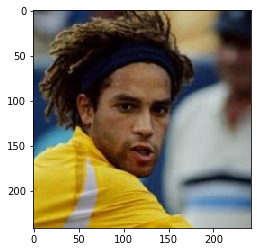

Instructions for updating:
Colocations handled automatically by placer.
Preprocessing image 1/1


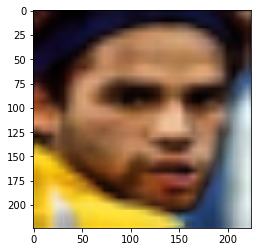

In [16]:
plt.imshow(x_train['0.jpg'])
plt.show()
xx=preprocess_imgs([x_train['0.jpg']],param={'crop_to_face':True, 'size_multiplier':1.2, 'adaptive_equalization':True, 'bottleneck_size':32})[0]
plt.imshow(xx)
plt.show()

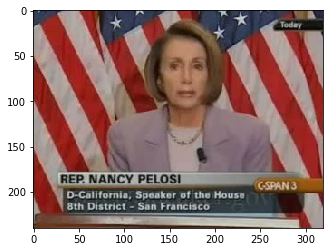

Preprocessing image 1/1


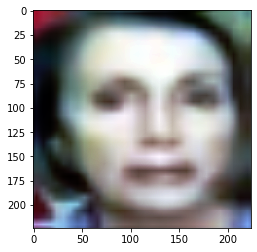

In [17]:
plt.imshow(video_test['0'][0])
plt.show()
xx=preprocess_imgs([video_test['0'][0]], param={'crop_to_face':True, 'size_multiplier':1.2, 'adaptive_equalization':False, 'bottleneck_size':32})[0]
plt.imshow(xx)
plt.show()

#### Visualization of preprocessing

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [18]:
import h5py
from tensorflow.keras.models import load_model
model = load_model(assignment_dir + '/face_recognition_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [19]:
def get_layer_output(images, layer = 'fc7'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    layers=layer.split('+')
    n_img = images.shape[0]

    output=np.zeros((images.shape[0],0))

    batch_size = 2
    
    for l in layers: 
      network_output = model.get_layer(l).output
      feature_extraction_model = Model(model.input, network_output)
         
      layer_output=zeros((n_img,feature_extraction_model.predict(images[0,:,:,:].reshape(1,224,224,3)).shape[1]))
    
      
    
      for i in range(int(ceil(n_img/batch_size))):
        layer_output[i*batch_size:min(n_img,(i+1)*batch_size),:]=feature_extraction_model.predict(
            images[i*batch_size:min(n_img,(i+1)*batch_size),:,:,:])  
        
    
      output=np.hstack((output,layer_output))
    return output

In [20]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print(out.shape)
print(out.dtype)

(1, 4096)
float64


### Training classifier (2 points)


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

Now we can build the classifier, fit it and use to predict the labels of testing images.

### Image classification quality (2 points)

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points — at least 0.95.

In [21]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

### Video classification quality (2 points)

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points — at least 0.85.

In [33]:
from sklearn import preprocessing
from sklearn import decomposition


from skimage.io import imread
import cv2
from os.path import join
class ClassifierVideoCatboost():
    def __init__(self, nn_model, frame_classifier, features_list, 
                 pca_fraction_dict={},
                 augment_param={'flip':True}, 
                 preprocess_param={'size_multiplier':2.15}):
        
        self.label_encoder = preprocessing.LabelEncoder()
        self.frame_classifier = frame_classifier
        self.features = features_list
        
        PCA_FRACTION=0.95
        
        self.pca_list =[decomposition.PCA(pca_fraction_dict.get(f,PCA_FRACTION)) for f in self.features]
         
        self.size_multiplier=2.15
        self.augment_param = augment_param
        self.preprocess_param=preprocess_param
        
    def fit(self, train_imgs, train_labels):
        n_images=len(train_imgs)
        image_counter=0
        
        labels_orig = []
        for id in train_imgs:
          labels_orig.append(train_labels[id])
        
        preprocessed_images = np.array(preprocess_imgs(train_imgs.values(), param=self.preprocess_param))
        if self.augment_param.get('flip', False):                               
            flipped_images=np.flip(preprocessed_images, -2)
            augmented_images = np.vstack((preprocessed_images, flipped_images))
            labels_orig.extend(labels_orig)
        else:
            augmented_images = preprocessed_images                               

        # augment images with two different scaling bottlenecks

#        bottleneck_70 = np.zeros_like(augmented_images)
#        bottleneck_110 = np.zeros_like(augmented_images)
##
#        n_augm = augmented_images.shape[0]
#        for i in range(n_augm):
#        bottleneck_70[i,:,:] = transform.resize(transform.resize(augmented_images[i], (70, 70)), (224, 224))
#        bottleneck_110[i,:,:] = transform.resize(transform.resize(augmented_images[i], (110, 110)), (224, 224))

#        labels_orig = labels_orig * 3
#        augmented_images = np.vstack((augmented_images, bottleneck_70, bottleneck_110))
        
#        blur1 = np.zeros_like(augmented_images)
#        blur2 = np.zeros_like(augmented_images)

#        n_augm = augmented_images.shape[0]
#        for i in range(n_augm):
#         blur1[i,:,:] = filters.gaussian(augmented_images[i])
#         blur2[i,:,:] = filters.gaussian(blur1[i])
         
#        labels_orig = labels_orig * 3
#        augmented_images = np.vstack((augmented_images, blur1, blur2))

#        print('augmented image set shape {}'.format(augmented_images.shape))

#        #flip the images of the second half horizontally

        n_augm = augmented_images.shape[0]

        x_train_internal =np.zeros((n_augm,0))
        for idx,p in enumerate(self.pca_list):
            pca = p.fit_transform(get_layer_output(augmented_images, layer=self.features[idx]))
            x_train_internal=np.hstack((x_train_internal, pca))
       
        print('training data shape:', x_train_internal.shape)
        
        y_train_internal = self.label_encoder.fit_transform(labels_orig)
        
        self.frame_classifier.fit(x_train_internal, y_train_internal)
        self.fitted=True

    def classify_images(self, test_imgs):
      assert self.fitted

      n_images=len(test_imgs)
      image_counter=0
      preprocess_result = np.array(preprocess_imgs(test_imgs.values(), param=self.preprocess_param))   
      x_test=np.zeros((n_images,0))
      for idx,p in enumerate(self.pca_list):
            pca = p.transform(get_layer_output(preprocess_result, layer=self.features[idx]))
            x_test=np.hstack((x_pred, pca))
            
      ids=[] 
      for id in test_imgs:
        ids.append(id)
        
      y_test=self.label_encoder.inverse_transform(self.catboost_model.predict(x_test))
      print('mapping predictions back')
      print(y_test.shape)
      for i in range(n_images):
        predictions[ids[i]] = str(y_test[i])
      return predictions
 
    def classify_videos(self, test_video, test_labels=None):
        assert self.fitted
        predictions={}

        video_step = 6

        preprocess_pool=[]
        pool_start={}
        pool_end={}

        # populate pool and preprocess all images in one lump
        for id in test_video:
          pool_start[id] = len(preprocess_pool) 
          preprocess_pool.extend(test_video[id][::video_step])
          pool_end[id] = len(preprocess_pool) 

        preprocess_result = np.array(preprocess_imgs(preprocess_pool, param=self.preprocess_param))
        
        x_pred_pool = np.zeros((len(preprocess_pool),0))
        
        for idx,p in enumerate(self.pca_list):
            pca = p.transform(get_layer_output(preprocess_result, layer=self.features[idx]))
            x_pred_pool=np.hstack((x_pred_pool, pca))  
          
        probs_pool = self.frame_classifier.predict_proba(x_pred_pool)
        prob_class_mean = np.mean(probs_pool, axis=0)
        prob_class_dev = np.std(probs_pool, axis=0)
          
        n_classes = probs_pool.shape[1] 
        class_names = self.label_encoder.inverse_transform(range(n_classes))
        for class_idx in range(n_classes):
            print('{} : mean {} stdev {}',class_names[class_idx],
                 prob_class_mean[class_idx], prob_class_dev[class_idx])
        
        y_pred_pool= self.label_encoder.inverse_transform(self.frame_classifier.predict(x_pred_pool).ravel())
        
        
        for id in test_video:
          print('classifying video id ',id )
          n_frames= pool_end[id]-pool_start[id] 
          lst=list(y_pred_pool[pool_start[id]:pool_end[id]])
          predictions[id]=max(set(lst), key=lst.count) # mode of y_pred
          
          if test_labels is not None: 
                if predictions[id] == test_labels[id]:
                    print('Correct prediction for video {}: {}'.format(id,predictions[id]))
                else:    
                    print('Incorrect prediction for video {}: {} (right is {})'.format(id,predictions[id],test_labels[id]))
                    probs=probs_pool[pool_start[id]:pool_end[id]]           
                    y_pred=y_pred_pool[pool_start[id]:pool_end[id]]           
                    for row in range(probs.shape[0]):
         #   print('Frame ',row)
             #plt.imshow(preprocess_result[pool_start[id]+row])
             #plt.show()
                         best_indices = probs[row,:].argsort()[-5:][::-1]
                         for i in range(5):
                              print('{} (p={})'.format(self.label_encoder.inverse_transform(best_indices)[i],
                                                   probs[row,best_indices[i]]))
                         print('Frame prediction: ',y_pred[row])

          else:  
              print('prediction for video {}: {}'.format(id,predictions[id]))

        return predictions

In [ ]:
len(video_test['0'][::2])


In [ ]:
# %%capture cap_out --no-stderr

#def extract_subdict(d, keys):
#    return dict((k, d[k]) for k in keys if k in d)
#
#difficult_labels=['10','14','16','29','35','40','43','49','5','50','53','54','57','59','63']
#testing_labels = ['0','1','11']+difficult_labels
#video_classifier = ClassifierVideo(model)
#video_classifier.fit(video_train, train_labels)
#y_video_difficult_out = video_classifier.classify_videos(extract_subdict(video_test, testing_labels))

In [34]:
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn import ensemble

# %%capture cap_out --no-stderr

#video_train_aug=video_train
#train_labels_aug=train_labels

#for lbl in x_train:
#    video_train_aug['img:'+lbl] = x_train[lbl]
#    train_labels_aug['img:'+lbl] = y_train[lbl]

preprocess_param = {'adaptive_equalization':True, 'size_multiplier':2.15, 'bottleneck_size':90}
augment_param = {'flip': False}

#cls=CatBoostClassifier(verbose=True, iterations=7000)
cls=kNN(n_neighbors=5)
# cls = ensemble.RandomForestClassifier(n_estimators=9000,verbose=1, n_jobs=-1)
video_classifier = ClassifierVideoCatboost(model,cls,['fc7'],preprocess_param=preprocess_param, augment_param=augment_param)
#video_classifier = ClassifierVideoCatboost(model,ensemble.RandomForestClassifier(n_estimators=4000,verbose=1, n_jobs=-1),['fc7'])

video_classifier.fit(video_train, train_labels)
#video_classifier.fit(video_train_aug, train_labels_aug)
y_video_out = video_classifier.classify_videos(video_test, test_labels)

print(check_test(y_video_out, test_labels))


Preprocessing image 1/729
Preprocessing image 11/729
Preprocessing image 21/729
Preprocessing image 31/729
Preprocessing image 41/729
Preprocessing image 51/729
Preprocessing image 61/729
Preprocessing image 71/729
Preprocessing image 81/729
Preprocessing image 91/729
Preprocessing image 101/729
Preprocessing image 111/729
Preprocessing image 121/729
Preprocessing image 131/729
Preprocessing image 141/729
Preprocessing image 151/729
Preprocessing image 161/729
Preprocessing image 171/729
Preprocessing image 181/729
Preprocessing image 191/729
Preprocessing image 201/729
Preprocessing image 211/729
Preprocessing image 221/729
Preprocessing image 231/729
Preprocessing image 241/729
Preprocessing image 251/729
Preprocessing image 261/729
Preprocessing image 271/729
Preprocessing image 281/729
Preprocessing image 291/729
Preprocessing image 301/729
Preprocessing image 311/729
Preprocessing image 321/729
Preprocessing image 331/729
Preprocessing image 341/729
Preprocessing image 351/729
Pre

In [ ]:
print(check_test(y_video_out, test_labels))

In [ ]:
video_classifier.pca.n_components_

In [ ]:
img_classifier = ClassifierVideo(model)
img_classifier.fit(x_train, y_train)
y_out = img_classifier.classify_images(x_test)
print(check_test(y_out, y_test))

In [ ]:
import gc
gc.collect()
%reset -f out

In [ ]:
test_labels